### Paketimporte

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Vorbereitung der Daten

Preise

In [2]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx")
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

Downtime

In [3]:
df_dt = (
    pd.read_excel("./../../data/Downtime.xlsx")
        .rename(columns={"Unnamed: 0": "year",
                         "Region A": "a",
                         "Region B": "b",
                         "Region C": "c",
                         "Region D": "d"})
)

Kundendaten

In [4]:
df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

Vereinen der Transaktionsdaten

In [10]:
def read_regio_data(region, kind):
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        year_month=lambda _data: _data["date"].dt.year.astype(str) + "_" + _data["date"].dt.month.astype(str),
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "transaction_id"]], on="transaction_id"))

df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifische Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)

### Vegleich der verschiedenen Modelle

#### Gewinnmargen

<Axes: xlabel='product', ylabel='profit_per_unit'>

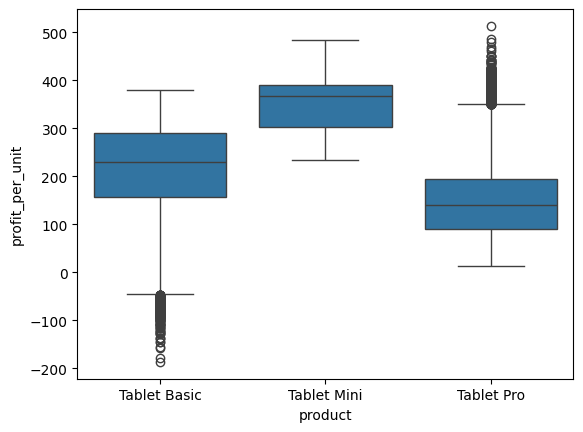

In [11]:
# Gewinnmargen für die drei Produkte basic, mini und pro darstellen
sns.boxplot(x="product", y="profit_per_unit", data=df_reg_main)

/var/folders/0z/hf0hhysx25v4c8md4jfmz7kr0000gn/T/ipykernel_34207/1164010019.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


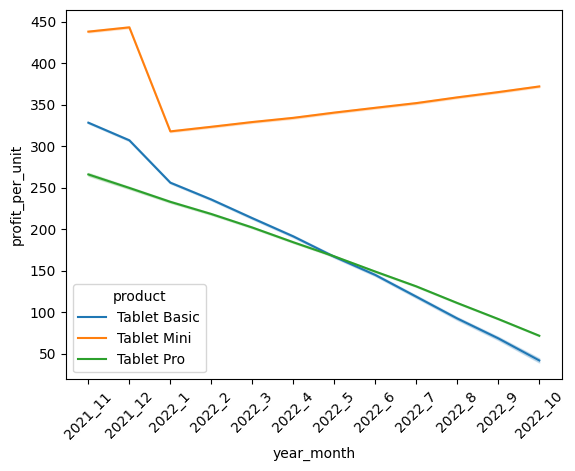

In [16]:
plot = sns.lineplot(x="year_month", y="profit_per_unit", hue="product", data=df_reg_main)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plt.show()

#### Verkaufszahlen & Erklärung

Erklärung noch etwas schwammig

<Axes: xlabel='product', ylabel='amount'>

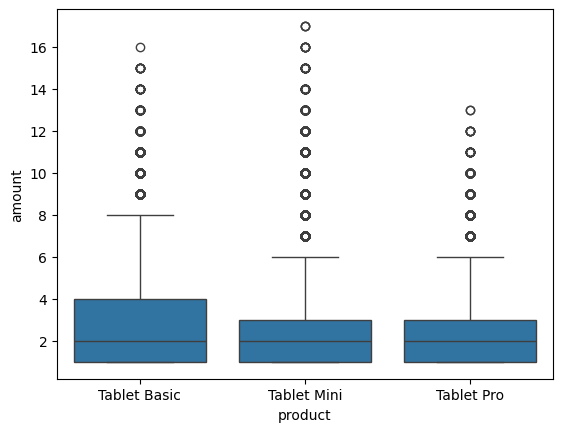

In [17]:
# Verkaufszahlen der drei Produkte basic, mini und pro darstellen
sns.boxplot(x="product", y="amount", data=df_reg_main)

In [18]:
df_reg_main.groupby(['product'])['amount'].mean()

product
Tablet Basic    2.815223
Tablet Mini     2.513773
Tablet Pro      2.119953
Name: amount, dtype: float64

In [23]:
df_reg_main.groupby(['product'])['amount'].sum()

product
Tablet Basic    211854
Tablet Mini     276515
Tablet Pro      317993
Name: amount, dtype: int64

/var/folders/0z/hf0hhysx25v4c8md4jfmz7kr0000gn/T/ipykernel_34207/744313651.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


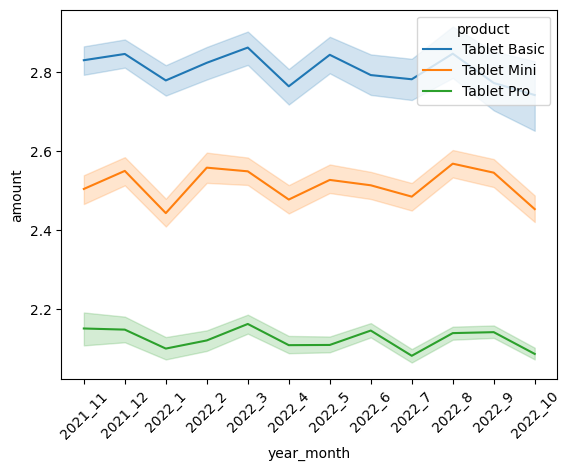

In [19]:
plot = sns.lineplot(x="year_month", y="amount", hue="product", data=df_reg_main)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plt.show()

#### Nach Markplatz aufschlüsseln

Sinken die Gewinne des Stores wegen bestimmter Modelle?

<Axes: xlabel='product', ylabel='amount'>

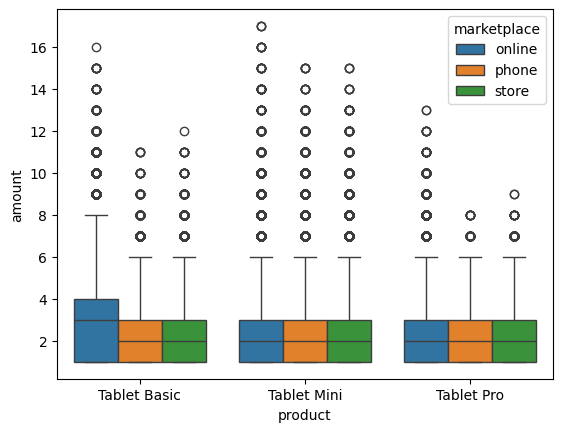

In [25]:
sns.boxplot(x="product", y="amount", hue="marketplace", data=df_reg_main)

In [31]:
df_reg_main.groupby(['product', 'marketplace'])['amount'].mean()

product       marketplace
Tablet Basic  online         2.947354
              phone          2.574840
              store          2.591037
Tablet Mini   online         2.815108
              phone          2.435970
              store          2.441162
Tablet Pro    online         2.435414
              phone          2.085969
              store          2.084329
Name: amount, dtype: float64

In [30]:
df_reg_main.groupby(['product', 'marketplace'])['amount'].sum()

product       marketplace
Tablet Basic  online         141081
              phone           29433
              store           41340
Tablet Mini   online          62273
              phone          133669
              store           80573
Tablet Pro    online          36558
              phone           93539
              store          187896
Name: amount, dtype: int64

In [32]:
# Show the amount of transactions per product and marketplace where the profit is negative
df_reg_main[df_reg_main['profit_per_unit'] < 0].groupby(['product', 'marketplace'])['transaction_id'].count()

product       marketplace
Tablet Basic  online           60
              phone            18
              store          1100
Name: transaction_id, dtype: int64